<a href="https://colab.research.google.com/github/lahirumanulanka/ann-visual-emotion/blob/new-dataset/notebooks/emo_CNN_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone new-dataset https://github.com/lahirumanulanka/ann-visual-emotion

Cloning into 'ann-visual-emotion'...
remote: Enumerating objects: 69079, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 69079 (delta 11), reused 2 (delta 0), pack-reused 69058 (from 1)
Receiving objects: 100% (69079/69079), 1.48 GiB | 47.00 MiB/s, done.
Resolving deltas: 100% (6823/6823), done.
Updating files: 100% (36079/36079), done.


In [ ]:
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Transfer learning imports
try:
    from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
    _MNV2_HAS_WEIGHTS = True
except Exception:
    from torchvision.models import mobilenet_v2  # type: ignore
    _MNV2_HAS_WEIGHTS = False

from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Data paths (modify if needed)
CSV_TRAIN = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits/train.csv')
CSV_VAL   = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits/val.csv')
CSV_TEST  = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits/test.csv')
LABEL_MAP_PATH = Path('/content/ann-visual-emotion/data/processed/EmoSet_splits/label_map.json')
DATA_DIR = Path('/content/ann-visual-emotion/data/raw/EmoSet')

# Load label map
with open(LABEL_MAP_PATH, 'r') as f:
    label_map = json.load(f)

num_classes = len(label_map)
print('Number of classes:', num_classes)

Using device: cuda
Number of classes: 7


In [4]:
class EmoDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None, label_map=None):
        self.df = dataframe.reset_index(drop=True)
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.label_map = label_map
        possible_path_cols = [c for c in self.df.columns if 'path' in c.lower() or 'file' in c.lower() or 'image' in c.lower()]
        self.path_col = possible_path_cols[0] if possible_path_cols else self.df.columns[0]
        possible_label_cols = [c for c in self.df.columns if 'label' in c.lower() or 'class' in c.lower() or 'emotion' in c.lower()]
        self.label_col = possible_label_cols[0] if possible_label_cols else self.df.columns[1]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        rel_path = row[self.path_col]
        label = row[self.label_col]
        if self.label_map and isinstance(label, str):
            label_idx = self.label_map[label]
        else:
            label_idx = int(label)
        img_path = self.root_dir / rel_path
        image = Image.open(img_path).convert('L')  # grayscale
        if self.transform:
            image = self.transform(image)
        return image, label_idx


In [5]:
# Improved data augmentation and normalization
mean = [0.5]
std  = [0.5]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(48, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load dataframes
train_df = pd.read_csv(CSV_TRAIN)
val_df   = pd.read_csv(CSV_VAL)
test_df  = pd.read_csv(CSV_TEST)

# Datasets
train_dataset = EmoDataset(train_df, DATA_DIR, transform=train_transform, label_map=label_map)
val_dataset   = EmoDataset(val_df, DATA_DIR, transform=val_transform, label_map=label_map)
test_dataset  = EmoDataset(test_df, DATA_DIR, transform=val_transform, label_map=label_map)

# DataLoaders
batch_size = 128  # bigger batch size for faster training on GPU
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


In [ ]:
# Transfer Learning CNN (MobileNetV2 backbone adapted for 1-channel input)
class TLMobileNet(nn.Module):
    def __init__(self, num_classes: int, freeze_backbone: bool = True):
        super().__init__()
        if _MNV2_HAS_WEIGHTS:
            weights = MobileNet_V2_Weights.DEFAULT
            backbone = mobilenet_v2(weights=weights)
        else:
            backbone = mobilenet_v2(pretrained=True)
        # Adapt first conv to 1 channel (average weights of RGB)
        first_conv = backbone.features[0][0]
        with torch.no_grad():
            w = first_conv.weight  # (32,3,3,3)
            w_gray = w.mean(1, keepdim=True)
        new_conv = nn.Conv2d(1, first_conv.out_channels, kernel_size=first_conv.kernel_size,
                             stride=first_conv.stride, padding=first_conv.padding, bias=False)
        new_conv.weight.data = w_gray
        backbone.features[0][0] = new_conv
        self.features = backbone.features
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        in_feat = backbone.classifier[1].in_features
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(in_feat, num_classes)
        )
        if freeze_backbone:
            for p in self.features.parameters():
                p.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Instantiate transfer learning model
use_transfer = True  # toggle this to switch between custom CNN and transfer learning
freeze_backbone = True
if use_transfer:
    model = TLMobileNet(num_classes, freeze_backbone=freeze_backbone).to(device)
    print("Using transfer learning MobileNetV2 (freeze_backbone=", freeze_backbone, ")")
else:
    # Fallback to earlier ImprovedCNN if desired
    class ImprovedCNN(nn.Module):
        def __init__(self, num_classes):
            super().__init__()
            self.block1 = nn.Sequential(
                nn.Conv2d(1, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
                nn.Conv2d(32, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
                nn.MaxPool2d(2), nn.Dropout(0.2)
            )
            self.block2 = nn.Sequential(
                nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
                nn.MaxPool2d(2), nn.Dropout(0.25)
            )
            self.block3 = nn.Sequential(
                nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
                nn.MaxPool2d(2), nn.Dropout(0.3)
            )
            self.block4 = nn.Sequential(
                nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
                nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
                nn.AdaptiveAvgPool2d((1, 1)), nn.Dropout(0.4)
            )
            self.fc = nn.Linear(256, num_classes)
        def forward(self, x):
            x = self.block1(x); x = self.block2(x); x = self.block3(x); x = self.block4(x)
            x = x.view(x.size(0), -1)
            return self.fc(x)
    model = ImprovedCNN(num_classes).to(device)
    print(model)

In [6]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.3)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Dropout(0.4)
        )
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = ImprovedCNN(num_classes).to(device)
print(model)


ImprovedCNN(
  (block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): 

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Collect only trainable parameters (support freezing backbone)
trainable_params = [p for p in model.parameters() if p.requires_grad]
num_trainable = sum(p.numel() for p in trainable_params)
num_total = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {num_trainable:,} / {num_total:,} ({num_trainable/num_total*100:.2f}% unfrozen)")

# Optimizer with weight decay (L2 regularization)
optimizer = torch.optim.Adam(trainable_params, lr=1e-3, weight_decay=1e-4)

# Learning rate scheduler: reduce LR on plateau
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)  # Removed verbose=True

In [ ]:
# Training parameters
num_epochs = 80
patience = 10  # early stopping patience
best_val_loss = float('inf')
best_state_dict = None
patience_counter = 0

for epoch in range(num_epochs):
    maybe_unfreeze(epoch)
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    # Validation
    model.eval()
    val_running_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()
    val_loss = val_running_loss / len(val_dataset)
    val_acc = val_correct / val_total

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {current_lr:.2e} | Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state_dict = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print('Early stopping: no improvement in', patience, 'epochs.')
            break

# Load best model weights
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)

Epoch 1/80 | Train loss: 1.6551, acc: 0.3382 | Val loss: 1.9233, acc: 0.2797
Epoch 2/80 | Train loss: 1.4044, acc: 0.4615 | Val loss: 1.4364, acc: 0.4656
Epoch 3/80 | Train loss: 1.3110, acc: 0.4983 | Val loss: 1.1843, acc: 0.5450
Epoch 4/80 | Train loss: 1.2638, acc: 0.5195 | Val loss: 1.1864, acc: 0.5464
Epoch 5/80 | Train loss: 1.2267, acc: 0.5340 | Val loss: 1.1450, acc: 0.5609
Epoch 6/80 | Train loss: 1.2030, acc: 0.5403 | Val loss: 1.1139, acc: 0.5811
Epoch 7/80 | Train loss: 1.1742, acc: 0.5542 | Val loss: 1.0890, acc: 0.5898
Epoch 8/80 | Train loss: 1.1629, acc: 0.5568 | Val loss: 1.0489, acc: 0.6016
Epoch 9/80 | Train loss: 1.1415, acc: 0.5672 | Val loss: 1.0677, acc: 0.5977
Epoch 10/80 | Train loss: 1.1299, acc: 0.5689 | Val loss: 1.0592, acc: 0.5983
Epoch 11/80 | Train loss: 1.1184, acc: 0.5767 | Val loss: 1.0524, acc: 0.6076
Epoch 12/80 | Train loss: 1.1080, acc: 0.5818 | Val loss: 1.0624, acc: 0.6045
Epoch 13/80 | Train loss: 1.0705, acc: 0.5961 | Val loss: 0.9834, acc: 0.

In [ ]:
# Optional: Gradual unfreeze schedule for transfer learning
unfreeze_after = 5  # epochs after which to unfreeze backbone (set None to keep frozen)
backbone_unfrozen = False

def maybe_unfreeze(epoch):
    global backbone_unfrozen, optimizer
    if use_transfer and not backbone_unfrozen and unfreeze_after is not None and epoch >= unfreeze_after:
        print(f"Unfreezing backbone at epoch {epoch}")
        for p in model.features.parameters():
            p.requires_grad = True
        backbone_unfrozen = True
        # Rebuild optimizer to include new params
        trainable_params = [p for p in model.parameters() if p.requires_grad]
        optimizer.param_groups.clear()
        optimizer.add_param_group({'params': trainable_params, 'lr': 5e-4})


Test Loss: 0.8823, Test Accuracy: 0.6674


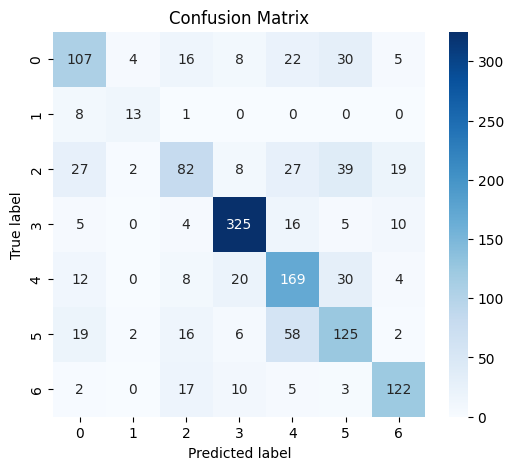

              precision    recall  f1-score   support

           0       0.59      0.56      0.58       192
           1       0.62      0.59      0.60        22
           2       0.57      0.40      0.47       204
           3       0.86      0.89      0.88       365
           4       0.57      0.70      0.63       243
           5       0.54      0.55      0.54       228
           6       0.75      0.77      0.76       159

    accuracy                           0.67      1413
   macro avg       0.64      0.64      0.64      1413
weighted avg       0.66      0.67      0.66      1413



In [9]:
# Evaluate on test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    test_running_loss = 0
    test_correct = 0
    test_total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (preds == labels).sum().item()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    test_loss = test_running_loss / len(test_dataset)
    test_acc = test_correct / test_total

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Confusion matrix and report
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_preds))